<a href="https://colab.research.google.com/github/Horadry/RAG-pipeline-Grimms-Fairy-Tales/blob/main/RAG_pipeline_GRIMM_Horadry_github.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install --quiet faiss-cpu langchain langchain-huggingface langchain_experimental langchain-community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.2/209.2 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 41.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.

In [3]:
import requests
from bs4 import BeautifulSoup
from langchain_text_splitters import SpacyTextSplitter
from langchain.docstore.document import Document as LangchainDocument
import tqdm
import torch
from transformers import pipeline, AutoTokenizer
from langchain.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores.utils import DistanceStrategy

In [4]:
URL = 'https://www.gutenberg.org/cache/epub/2591/pg2591-images.html'
EMBEDDING_MODEL = "mixedbread-ai/mxbai-embed-large-v1"
MODEL = 'tiiuae/Falcon3-3B-Base-1.58bit'

# **Load Documents**

In [5]:
# Scrape HTML content from the URL and extract specific chapters
def create_documents(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    chapters = soup.find_all('div', class_='chapter')
    frog_prince = str(chapters[12])
    hansel_and_gretel = str(chapters[19])
    little_red_cap = str(chapters[22])
    snowdrop = str(chapters[31])
    ashputtel = str(chapters[35])
    documents = [frog_prince, hansel_and_gretel, little_red_cap, snowdrop, ashputtel]
    return documents

In [6]:
documents = create_documents(URL)

In [7]:
len(documents)

5

In [8]:
documents[0]

'<div class="chapter">\n<h2><a id="link2H_4_0013"></a>\r\n      THE FROG-PRINCE\r\n    </h2>\n<p>\r\n      One fine evening a young princess put on her bonnet and clogs, and went\r\n      out to take a walk by herself in a wood; and when she came to a cool\r\n      spring of water, that rose in the midst of it, she sat herself down to\r\n      rest a while. Now she had a golden ball in her hand, which was her\r\n      favourite plaything; and she was always tossing it up into the air, and\r\n      catching it again as it fell. After a time she threw it up so high that\r\n      she missed catching it as it fell; and the ball bounded away, and rolled\r\n      along upon the ground, till at last it fell down into the spring. The\r\n      princess looked into the spring after her ball, but it was very deep, so\r\n      deep that she could not see the bottom of it. Then she began to bewail her\r\n      loss, and said, ‘Alas! if I could only get my ball again, I would give all\r\n      my fi

# **Split Documents into Chunks**

In [9]:
# Split documents into chunks
def create_chunks(documents):
    text_splitter = SpacyTextSplitter(chunk_size=500)
    texts = [text_splitter.split_text(doc) for doc in documents]

    text_list = []
    for i in range(len(texts)):
        for j in range(len(texts[i])):
            text_list.append(texts[i][j])
    chunks = [LangchainDocument(page_content=doc, metadata={"chunk": i}) for i, doc in enumerate(tqdm.tqdm(text_list))]

    return chunks

In [10]:
chunks = create_chunks(documents)

/usr/local/lib/python3.11/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
100%|██████████| 197/197 [00:00<00:00, 169180.57it/s]


In [11]:
len(chunks)

197

In [12]:
chunks[0]

Document(metadata={'chunk': 0}, page_content='<div class="chapter">\n<h2><a id="link2H_4_0013"></a>\r\n      THE FROG-PRINCE\r\n    </h2>\n<p>\r\n      \n\nOne fine evening a young princess put on her bonnet and clogs, and went\r\n      out to take a walk by herself in a wood; and when she came to a cool\r\n      spring of water, that rose in the midst of it, she sat herself down to\r\n      rest a while.')

In [13]:
len(chunks[0].page_content)

346

# **Create FAISS Vector Database**

In [14]:
# Initializing embeddimg model
embedding_model = HuggingFaceEmbeddings(
    model_name=EMBEDDING_MODEL,
    multi_process=True,
    # Cosine similarity
    encode_kwargs={"normalize_embeddings": True})

# Create and store embeddings in a FAISS vector database
faiss_db = FAISS.from_documents(chunks, embedding_model, distance_strategy=DistanceStrategy.COSINE)

<ipython-input-14-45bae761ddf6>:2: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_model = HuggingFaceEmbeddings(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/266 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/114k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/677 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/670M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/297 [00:00<?, ?B/s]

# **Create Tokenizer & Pipeline**

In [15]:
# Load tokenizer model
tokenizer = AutoTokenizer.from_pretrained(MODEL)

# Initialize pipeline
pipeline = pipeline(
    "text-generation",
    model=MODEL,
    tokenizer=tokenizer,
    torch_dtype=torch.bfloat16,
    trust_remote_code=True,
    device_map="auto",
    temperature = 0.0)

tokenizer_config.json:   0%|          | 0.00/362k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.78M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/686 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/968 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.22G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/118 [00:00<?, ?B/s]

Device set to use cuda:0


# **RAG**

In [16]:
def retrieval(user_query):
  retrieved_docs = faiss_db.similarity_search(query=user_query, k=5)
  return retrieved_docs


def generate_answer(retrieved_docs, user_query, max_new_tokens):
  input_text = (f"Context: {retrieved_docs[0].page_content}\n\n Question: {user_query}")
  generated_text = pipeline(
    input_text,
    max_new_tokens=max_new_tokens,
    num_beams=1,
    no_repeat_ngram_size=1,
    early_stopping=True)
  print("The answer is: ", generated_text[0]['generated_text'])
  return generated_text

# **- - - QUESTIONS - - -**

# **1. Question: Ashputtel**

🔎**What kind of plant did Ashputtel have?**

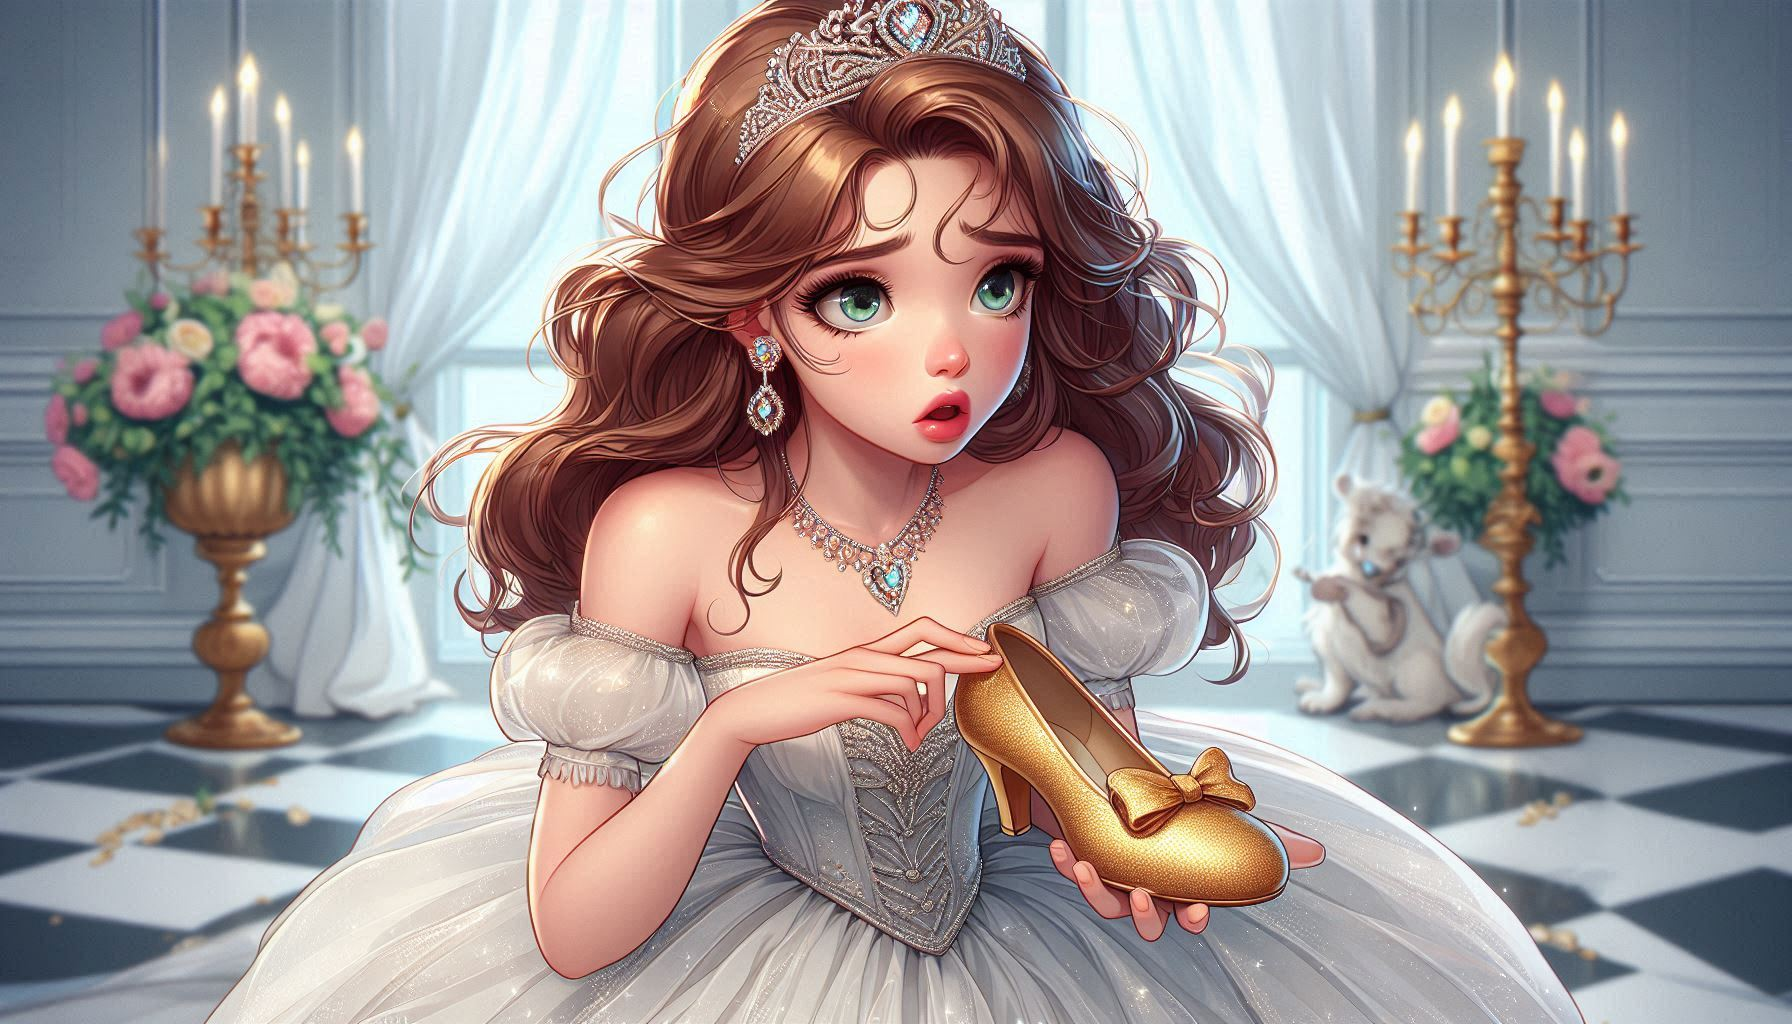

In [32]:
user_query = "What kind of plant did Ashputtel have?"
retrieved_docs = retrieval(user_query)
print('===============================================================================')
generated_answer = generate_answer(retrieved_docs, user_query, 15)
print('===============================================================================')

Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


The answer is:  Context: The father thought to himself, ‘Can it be Ashputtel?’
      

So he had an axe brought; and they cut down the tree, but found no one
      upon it.

And when they came back into the kitchen, there lay Ashputtel
      among the ashes; for she had slipped down on the other side of the tree,
      and carried her beautiful clothes back to the bird at the hazel-tree, and
      then put on her little grey frock.
    

</p>
<p>

 Question: What kind of plant did Ashputtel have? Answer:: A hazelnut.|


# **2. Question: Snowdrop**

🔎 **What did the first little dwarf say when he entered the cottage?**

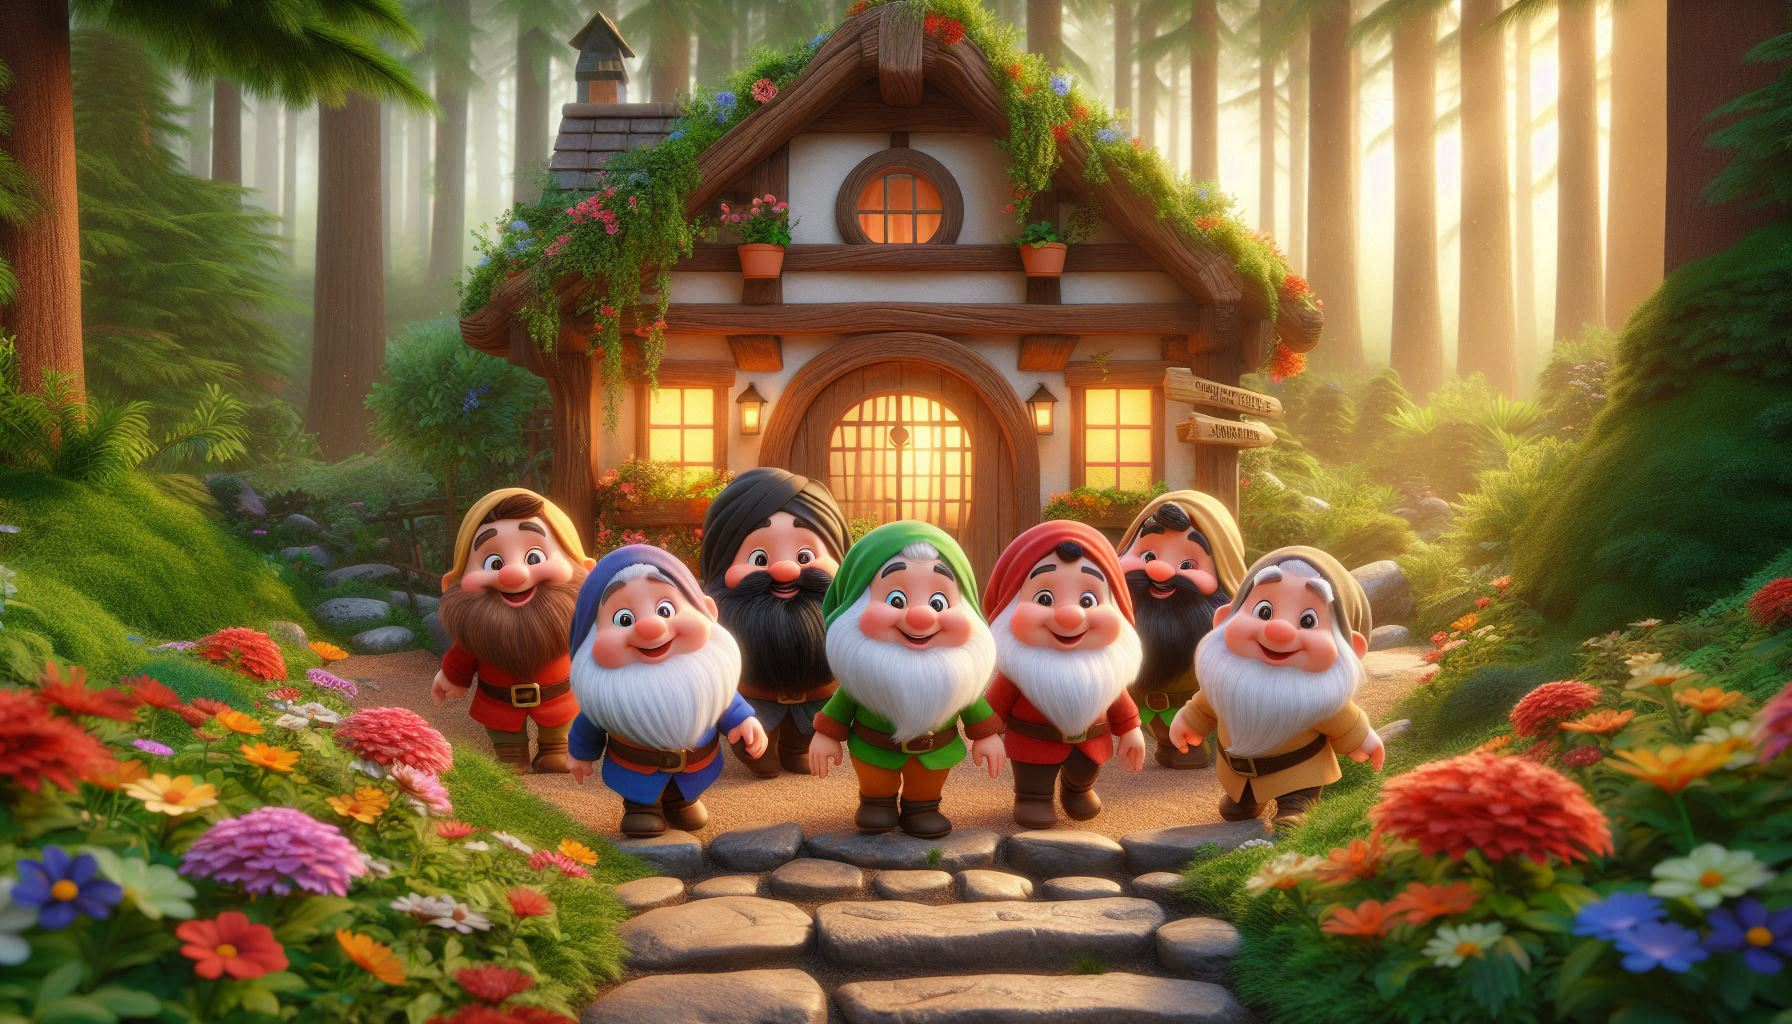

In [33]:
user_query = "What did the first little dwarf say when he entered the cottage?"
retrieved_docs = retrieval(user_query)
print('===============================================================================')
generated_answer = generate_answer(retrieved_docs, user_query, 10)
print('===============================================================================')

Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


The answer is:  Context: </p>
<p>
      By and by in came the masters of the cottage.

Now they were seven little
      dwarfs, that lived among the mountains, and dug and searched for gold.
      

They lighted up their seven lamps, and saw at once that all was not right.
      

The first said, ‘Who has been sitting on my stool?’

The second, ‘Who has
      been eating off my plate?’

The third, ‘Who has been picking my bread?’

The
      fourth, ‘Who has been meddling with my spoon?’

 Question: What did the first little dwarf say when he entered the cottage? Answer:: He asked who had sat upon his seat


# **3. Question: Little Red-Cap**

🔎 **What color is Little Red-Cap's cap?**

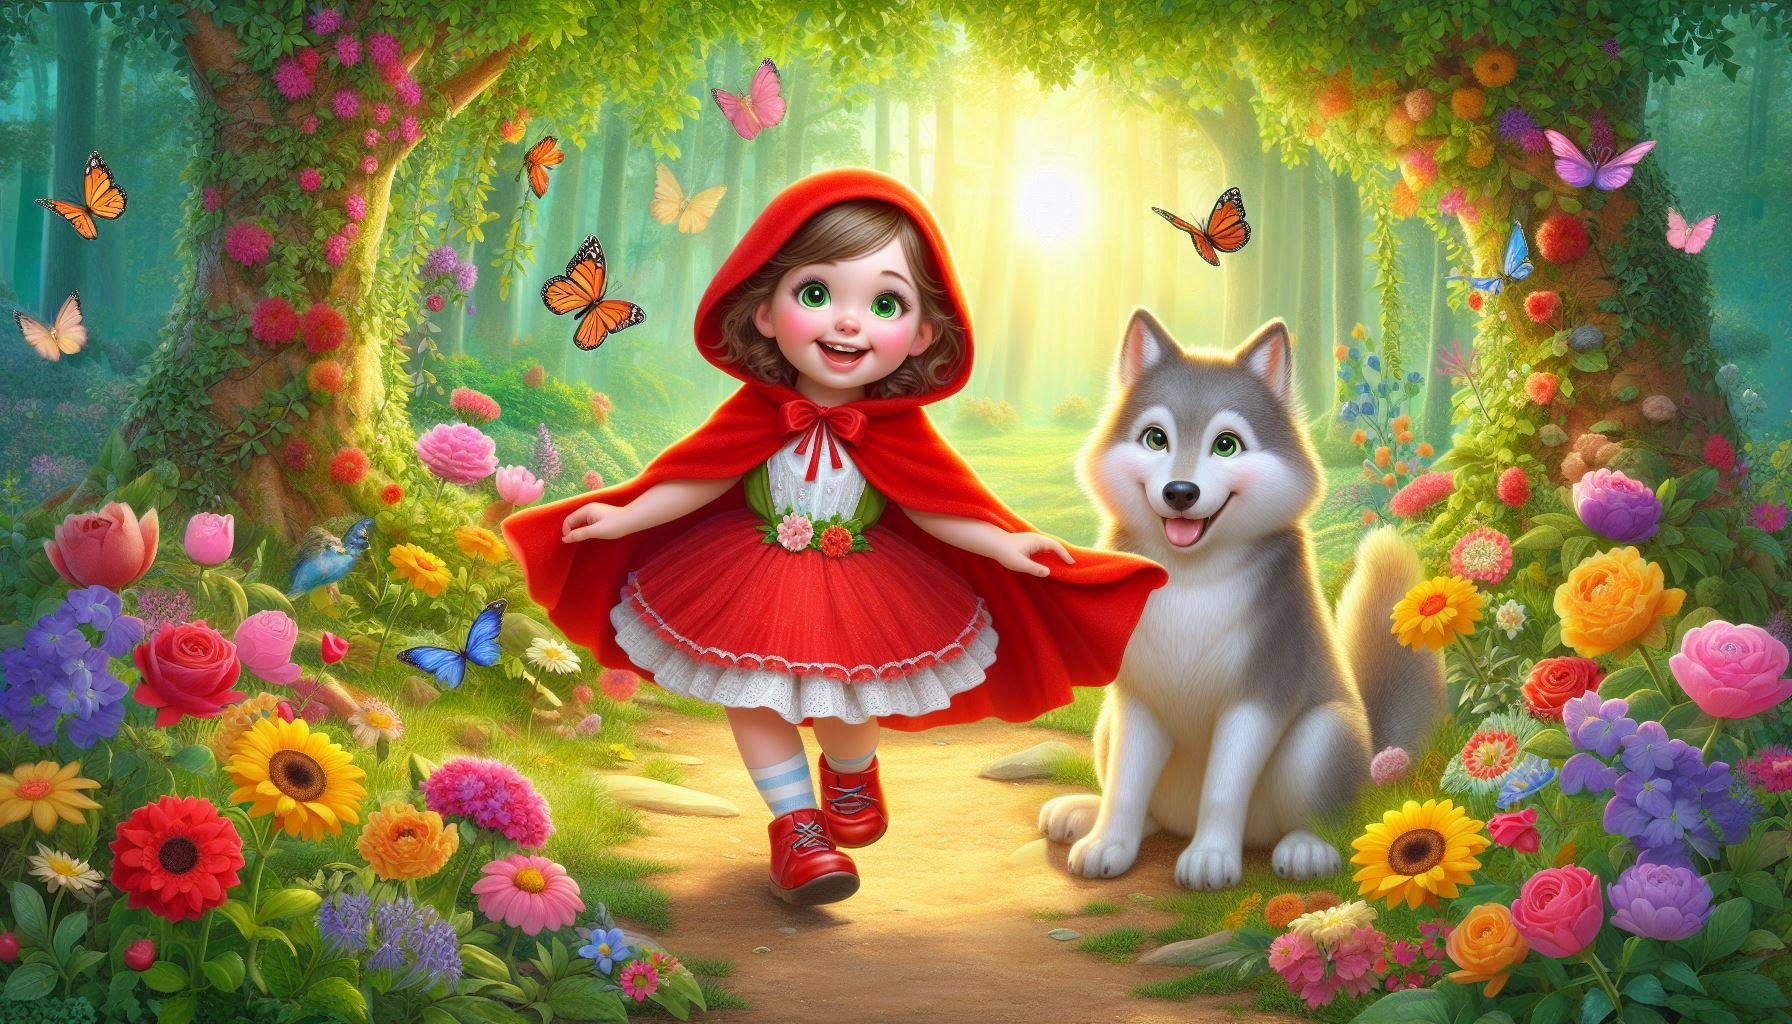

In [40]:
user_query = "What color is Little Red-Cap's cap?"
retrieved_docs = retrieval(user_query)
print('===============================================================================')
generated_answer = generate_answer(retrieved_docs, user_query, 10)
print('===============================================================================')

Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


The answer is:  Context: Once she gave her a
      little cap of red velvet, which suited her so well that she would never
      wear anything else; so she was always called ‘Little Red-Cap.’
    

</p>
<p>
      

One day her mother said to her: ‘Come, Little Red-Cap, here is a piece of
      cake and a bottle of wine; take them to your grandmother, she is ill and
      weak, and they will do her good.

 Question: What color is Little Red-Cap's cap? Answer::Red|


# **4. Question: Hansel and Gretel**

🔎 **What did Hansel do to the roof of the cottage?**

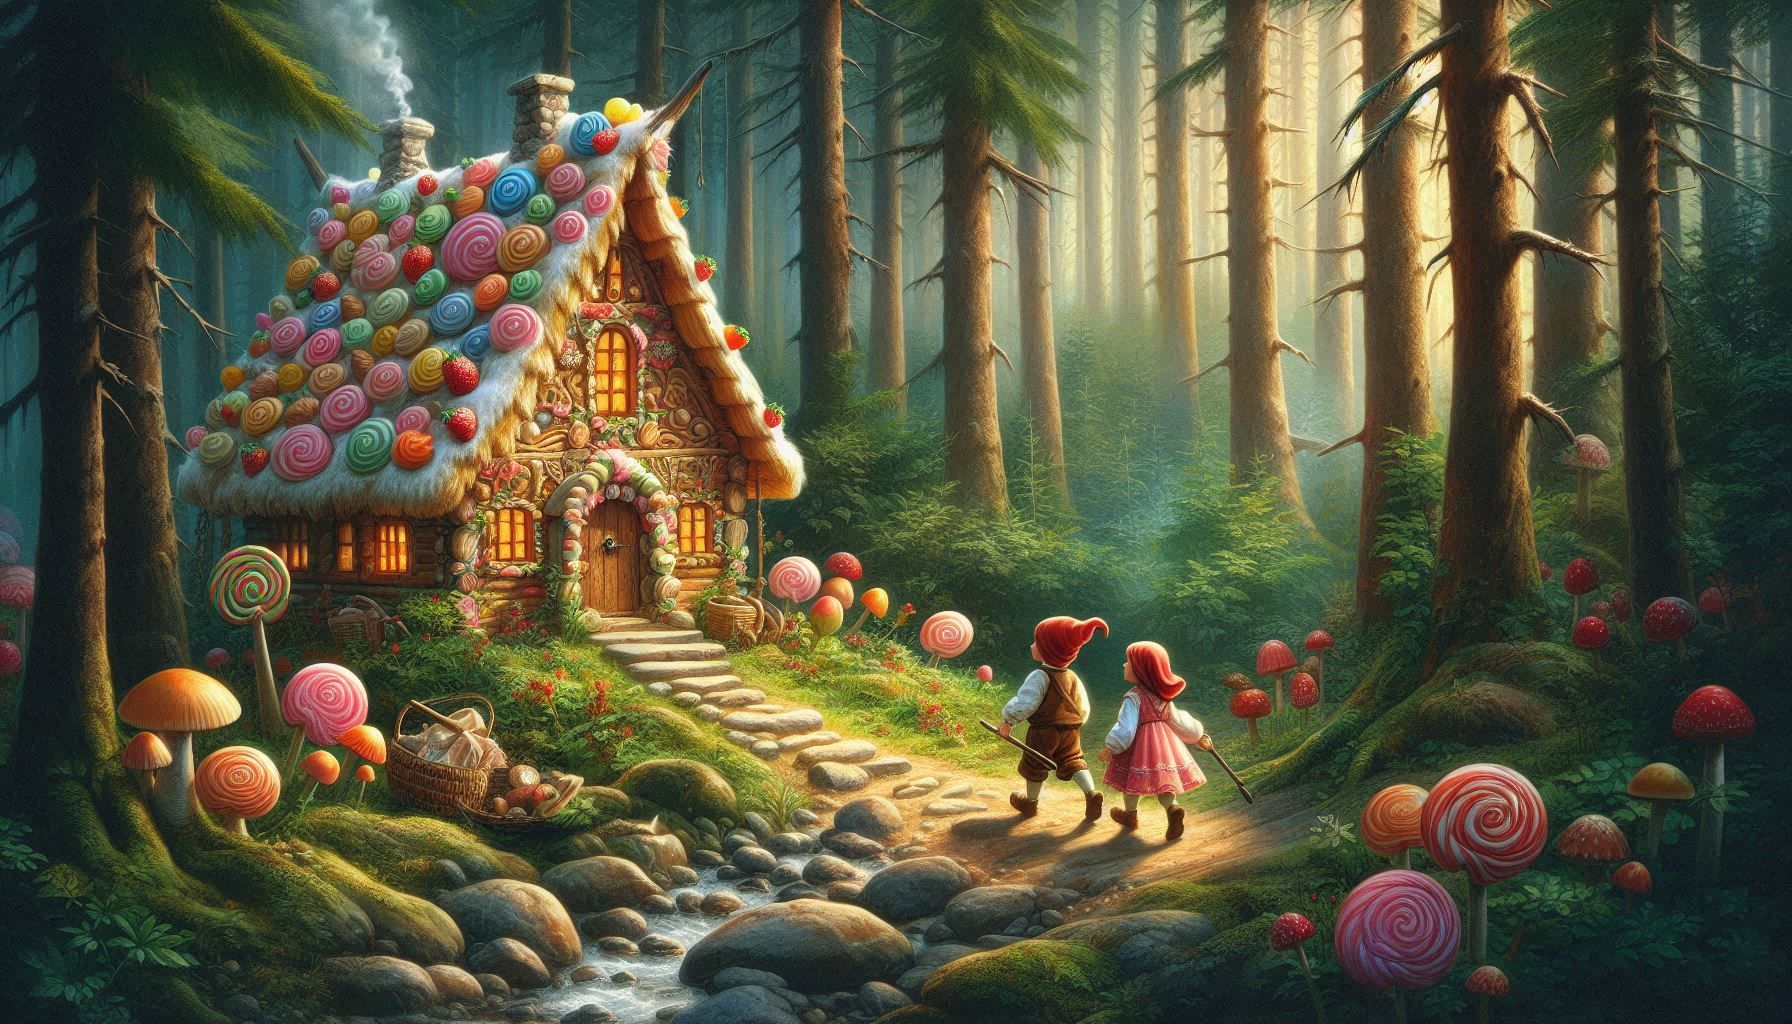

In [36]:
user_query =  "What did Hansel do to the roof of the cottage?"
retrieved_docs = retrieval(user_query)
print('===============================================================================')
generated_answer = generate_answer(retrieved_docs, user_query, 9)
print('===============================================================================')

Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


The answer is:  Context: ‘We will set to work on that,’ said Hansel, ‘and have a good meal.
      

I will eat a bit of the roof, and you Gretel, can eat some of the window,
      it will taste sweet.’

Hansel reached up above, and broke off a little of
      the roof to try how it tasted, and Gretel leant against the window and
      nibbled at the panes.

Then a soft voice cried from the parlour:
    </p>
<pre>
 ‘Nibble, nibble, gnaw,
  Who is nibbling at my little house?’


</pre>
<p>

 Question: What did Hansel do to the roof of the cottage? Answer:: He took pieces out for his supper


# **5. Question: The Frog Prince**

🔎 **Which animal found the princess's golden ball in the well?**

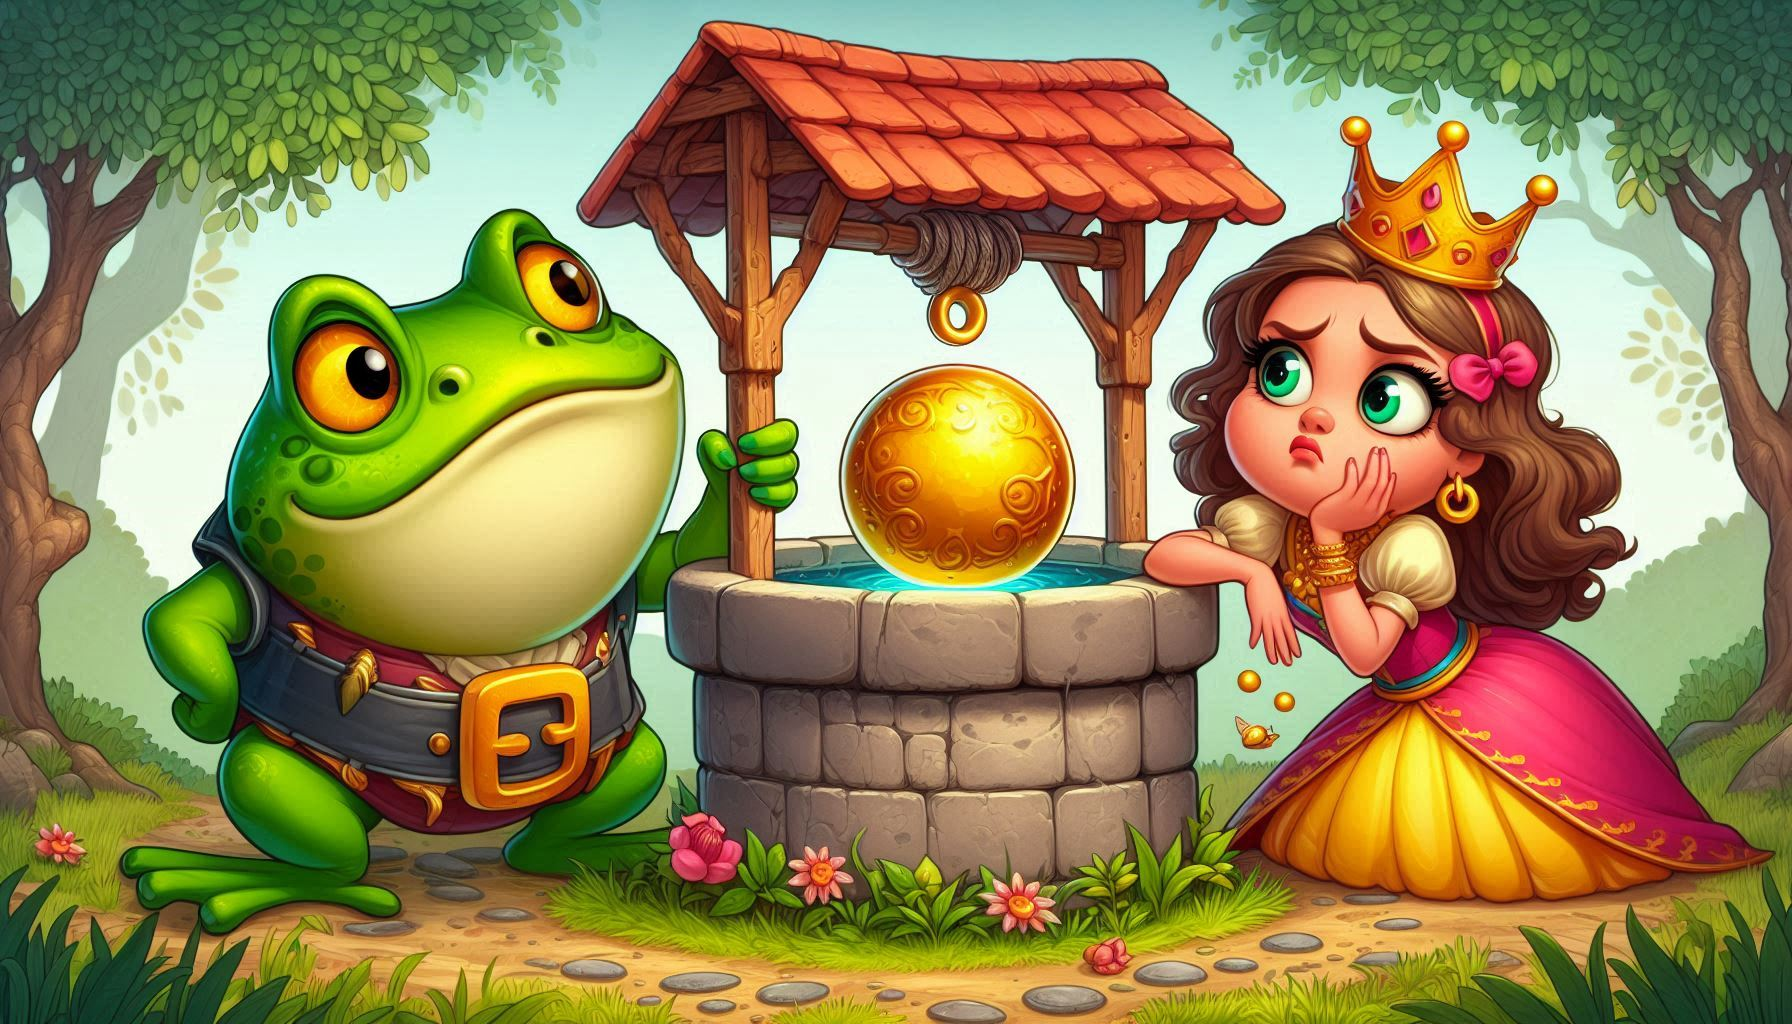

In [37]:
user_query = "Which animal found the princess's golden ball in the well?"
retrieved_docs = retrieval(user_query)
print('===============================================================================')
generated_answer = generate_answer(retrieved_docs, user_query, 7)
print('===============================================================================')

Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


The answer is:  Context: Then the frog put his head down, and dived deep under the water;
      and after a little while he came up again, with the ball in his mouth, and
      threw it on the edge of the spring.

As soon as the young princess saw her
      ball, she ran to pick it up; and she was so overjoyed to have it in her
      hand again, that she never thought of the frog, but ran home with it as
      fast as she could.

 Question: Which animal found the princess's golden ball in the well? (Frog)
